In [1]:
# -*- coding: utf-8 -*-
# @author: tongzi
# @description: combining different models for ensemble learing
# @created date: 2019/09/03
# @last modification: 2019/09/04

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

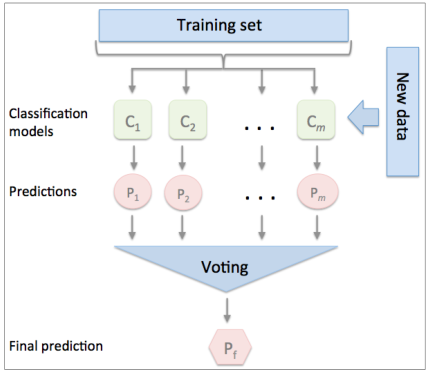

In [3]:
from scipy.special import comb

In [4]:
import math

In [5]:
def ensemble_error(n_classifiers, error):
    k_start = math.ceil(n_classifiers / 2.0)
    probs = [comb(n_classifiers, k) * error**k * (1-error)**(n_classifiers - k) 
            for k in range(k_start, n_classifiers+1)]
    return np.sum(probs)

In [6]:
print(f'{ensemble_error(n_classifiers=11, error=.25):.3f}')

0.034


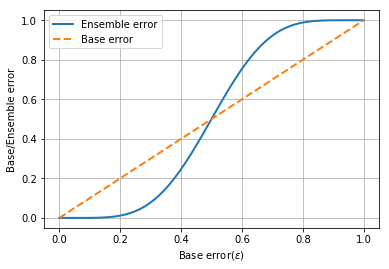

In [7]:
error_range = np.arange(0.0, 1.01, 0.01)
ens_error = [ensemble_error(n_classifiers=11, error=error) for
            error in error_range]
plt.plot(error_range, ens_error, label='Ensemble error', linewidth=2)
plt.plot(error_range, error_range, linestyle='--', label='Base error', linewidth=2)
plt.legend(loc='upper left')
plt.xlabel('Base error($\epsilon$)')
plt.ylabel('Base/Ensemble error')
plt.grid(True)

In [8]:
np.bincount([0, 0, 1], weights=[0.2, 0.2, 0.6])

array([0.4, 0.6])

In [9]:
np.argmax(np.bincount([0, 0, 1], weights=[0.2, 0.2, 0.6]))

1

$$\hat{y} = \mathop{\arg\max_i} \sum_{j=1}^m w_j p_{ij}$$

In [10]:
ex = np.array([[0.9, 0.1],
              [0.8, 0.2],
              [0.4, 0.6]])

In [11]:
p = np.average(ex, axis=0, weights=[0.2, 0.2, 0.6])

In [12]:
p

array([0.58, 0.42])

In [13]:
np.argmax(p)

0

### Implementing a simple majority vote classifier

In [14]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import operator

In [15]:
class MajorVoteClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value 
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
        
    def fit(self, X, y):
        self.labelenc_ = LabelEncoder()
        self.labelenc_.fit(y)
        self.classes_ = self.labelenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.labelenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self, X):
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(lambda x:
                                           np.argmax(np.bincount(x, weights=self.weights)),
                                          axis=1, arr=predictions)
        maj_vote = self.labelenc_.inverse_transform(maj_vote)
        return maj_vote
    
    def predict_proba(self, X):
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba
    
    def get_params(self, deep=True):
        if not deep:
            return super(MajorVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    #print(f'{name}__{key}')
                    out[f'{name}__{key}'] = value
            return out

In [16]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [17]:
iris = datasets.load_iris()

In [18]:
X, y = iris.data[50:, [1, 2]], iris.target[50:]

In [19]:
le = LabelEncoder()

In [20]:
y = le.fit_transform(y)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.5, random_state=1)

In [22]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline


In [23]:
clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=0)

In [24]:
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)

In [25]:
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

In [26]:
pipe1 = Pipeline([('sc', StandardScaler()),
                 ('clf', clf1)])

In [27]:
pipe2 = Pipeline([('sc', StandardScaler()),
                 ('clf', clf2)])

In [28]:
pipe3 = Pipeline([('sc', StandardScaler()),
                 ('clf', clf3)])

In [29]:
clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN']

In [30]:
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, 
                             scoring='roc_auc')
    print(f'ROC AUC: {scores.mean():.2f} (+/- {scores.std():.2f}) [{label}]')

ROC AUC: 0.92 (+/- 0.20) [Logistic Regression]
ROC AUC: 0.92 (+/- 0.15) [Decision Tree]
ROC AUC: 0.93 (+/- 0.10) [KNN]


In [31]:
mv_clf = MajorVoteClassifier(classifiers=[pipe1, clf2, pipe3])

In [32]:
clf_labels.append('Major Voting')

In [33]:
all_clf = [pipe1, clf2, pipe3, mv_clf]

In [34]:
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, 
                             scoring='roc_auc')
    print(f'ROC AUC: {scores.mean():.2f} (+/- {scores.std():.2f}) [{label}]')

ROC AUC: 0.92 (+/- 0.20) [Logistic Regression]
ROC AUC: 0.92 (+/- 0.15) [Decision Tree]
ROC AUC: 0.93 (+/- 0.10) [KNN]
ROC AUC: 0.97 (+/- 0.10) [Major Voting]


### Evaluating and tuning the ensemble classifier

In [35]:
from sklearn.metrics import roc_curve, auc

Text(0,0.5,'True positive rate')

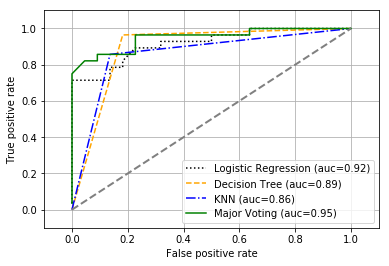

In [36]:
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label=f'{label} (auc={roc_auc:.2f})')
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)
plt.grid(True)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')


In [37]:
mv_clf.get_params()

{'pipeline-1': Pipeline(memory=None,
      steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False))]),
 'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=0,
             splitter='best'),
 'pipeline-2': Pipeline(memory=None,
      steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=No

In [38]:
from sklearn.grid_search import GridSearchCV

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [39]:
params = {'decisiontreeclassifier__max_depth': [1, 2], 
         'pipeline-1__clf__C': [0.001, 0.1, 100.0]}

In [40]:
grid = GridSearchCV(estimator=mv_clf, param_grid=params, cv=10, scoring='roc_auc')

In [41]:
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=MajorVoteClassifier(classifiers=[Pipeline(memory=None,
     steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', ra...ski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform'))])],
          vote='classlabel', weights=None),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'decisiontreeclassifier__max_depth': [1, 2], 'pipeline-1__clf__C': [0.001, 0.1, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [42]:
for params, mean_score, scores in grid.grid_scores_:
    print(f'{mean_score:.3f} +/-{scores.std()/2:.3f} {params}')
    #print(scores)

0.967 +/-0.050 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.967 +/-0.050 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
1.000 +/-0.000 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.967 +/-0.050 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.967 +/-0.050 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
1.000 +/-0.000 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [43]:
print(f'Best parameters: {grid.best_params_}')

Best parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}


### Bagging- building an ensemble of classifiers from bootstrap samples  
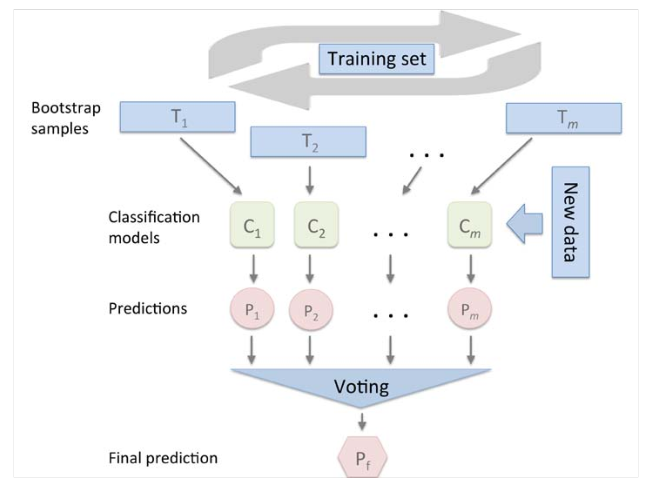  
>bootstrap samples (random samples with replacement)

#### 蝴蝶函数  
$$ x = sin(t)\left(e^{cos(t)} - 2cos(4t)-sin^5\left(\frac{t}{12}\right) \right) $$  
$$ y = cos(t)\left(e^{cos(t)} - 2cos(4t)-sin^5\left(\frac{t}{12}\right) \right) $$

In [49]:
t = np.linspace(-12*np.pi, 12*np.pi, 1000)
x = np.sin(t)*(np.exp(np.cos(t)) - 2*np.cos(4*t) - (np.sin(t/12.0))**2)
y = np.cos(t)*(np.exp(np.cos(t)) - 2*np.cos(4*t) - (np.sin(t/12.0))**2)

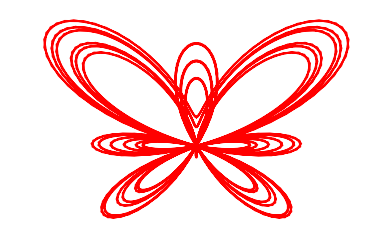

In [50]:
plt.axis('off')
plt.plot(x, y, color='red', linewidth=2)

In [51]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

In [52]:
df_wine.columns = ['Class label', 'Alcohol',
... 'Malic acid', 'Ash',
... 'Alcalinity of ash',
... 'Magnesium', 'Total phenols',
... 'Flavanoids', 'Nonflavanoid phenols',
... 'Proanthocyanins',
... 'Color intensity', 'Hue',
... 'OD280/OD315 of diluted wines',
... 'Proline']

In [56]:
df_wine = df_wine[df_wine['Class label'] != 1]

In [59]:
y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'Hue']].values

In [61]:
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=1)

In [63]:
from sklearn.ensemble import BaggingClassifier

In [64]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=None)

In [66]:
bag = BaggingClassifier(base_estimator=tree, n_estimators=500, max_samples=1.0,
                       max_features=1.0, bootstrap=True, bootstrap_features=False,
                       n_jobs=1, random_state=1)

In [67]:
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [68]:
y_train_pred = tree.predict(X_train)

In [70]:
from sklearn.metrics import accuracy_score

In [69]:
y_test_pred = tree.predict(X_test)

In [71]:
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)

In [73]:
print(f'Decision tree train/test accuracies: {tree_train:.3f}/{tree_test:.3f}')

Decision tree train/test accuracies: 1.000/0.854


Based on the accuracy values that we printed by executing the preceding
code snippet, the unpruned decision tree predicts all class labels of the training
samples correctly; however, the substantially lower test accuracy indicates high
variance (overfitting) of the model:

In [74]:
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print(f'Bagging train/test accuracies: {bag_train:.3f}/{bag_test:.3f}')

Bagging train/test accuracies: 1.000/0.896


Although the training accuracies of the decision tree and bagging classifier are
similar on the training set (both 1.0), we can see that the bagging classifier has a
slightly better generalization performance as estimated on the test set.

**section summary:**  
We only looked at a very simple bagging example in this section. In practice, more
complex classification tasks and datasets' high dimensionality can easily lead to
overfitting in single decision trees and this is where the bagging algorithm can really
play out its strengths. Finally, we shall note that the bagging algorithm can be an
effective approach to reduce the variance of a model. However, bagging is ineffective
in reducing model bias, which is why we want to choose an ensemble of classifiers
with low bias, for example, unpruned decision trees.

### Leveraging weak learner via adaptive boosting

In this section about ensemble methods, we will discuss boosting with a special
focus on its most common implementation, AdaBoost (short for Adaptive Boosting). 
  
In boosting, the ensemble consists of very simple base classifiers, also often referred to as weak learners, that have only a slight performance advantage over random guessing. A typical example of a weak learner would be a decision tree stump.
The key concept behind boosting is to focus on training samples that are hard
to classify, that is, to let the weak learners subsequently learn from misclassified
training samples to improve the performance of the ensemble. In contrast to bagging,
the initial formulation of boosting, the algorithm uses random subsets of training
samples drawn from the training dataset without replacement.  

(1) Draw a random subset of training samples $d_1$ without replacement from the
training set $D$ to train a weak learner $C_1$;  
(2) Draw second random training subset $d_2$ without replacement from the
training set $D$ and add 50 percent of the samples that were previously misclassified to train a weak learner $C_2$;  
(3) Find the training samples $d_3$ in the training set $D$ on which $C_1$ and $C_2$
disagree to train a third weak learner $C_3$;  
(4) Combine the week learners $C_1$, $C_2$, and $C_3$ via majority voting.

In contrast to the original boosting procedure as described here, AdaBoost uses
the complete training set to train the weak learners where the training samples are
reweighted in each iteration to build a strong classifier that learns from the mistakes of the previous weak learners in the ensemble. Before we dive deeper into the specific details of the AdaBoost algorithm, let's take a look at the following
figure to get a better grasp of the basic concept behind AdaBoost:  
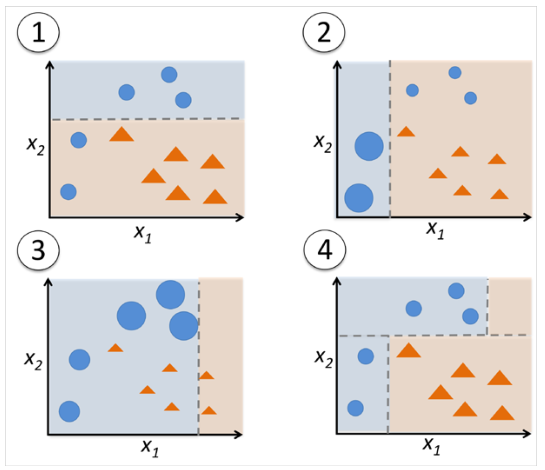

let's now train an AdaBoost ensemble classifier via scikit-learn. We will use the same Wine subset that we used in the previous section to train the bagging meta-classifier. Via the base_estimator attribute, we will train the AdaBoostClassifier on 500 decision tree stumps:

In [75]:
from sklearn.ensemble import AdaBoostClassifier

In [76]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=1)

In [77]:
ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500, learning_rate=.1,
                        random_state=0)

In [78]:
tree = tree.fit(X_train, y_train)

In [79]:
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print(f'Decision tree train/test accuracies: {tree_train:.3f}/{tree_test:.3f}')

Decision tree train/test accuracies: 0.845/0.854


As we can see, the decision tree stump seems to overfit the training data in contrast
with the unpruned decision tree that we saw in the previous section:

In [80]:
ada = ada.fit(X_train, y_train)

In [81]:
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print(f'Adaboost train/test accuracies: {ada_train:.3f}/{ada_test:.3f}')

Adaboost train/test accuracies: 1.000/0.875


As we can see, the AdaBoost model predicts all class labels of the training set
correctly and also shows a slightly improved test set performance compared to the
decision tree stump. However, we also see that we introduced additional variance by
our attempt to reduce the model bias.

Although we used another simple example for demonstration purposes, we can
see that the performance of the AdaBoost classifier is slightly improved compared
to the decision stump and achieved very similar accuracy scores to the bagging
classifier that we trained in the previous section. However, we should note that it is considered as bad practice to select a model based on the repeated usage of the test set. The estimate of the generalization performance may be too optimistic, which we discussed in more detail in *Chapter 6, Learning Best Practices for Model Evaluation and Hyperparameter Tuning.*

By looking at the decision regions, we can see that the decision boundary of the
AdaBoost model is substantially more complex than the decision boundary of the
decision stump. In addition, we note that the AdaBoost model separates the feature
space very similarly to the bagging classifier that we trained in the previous section.
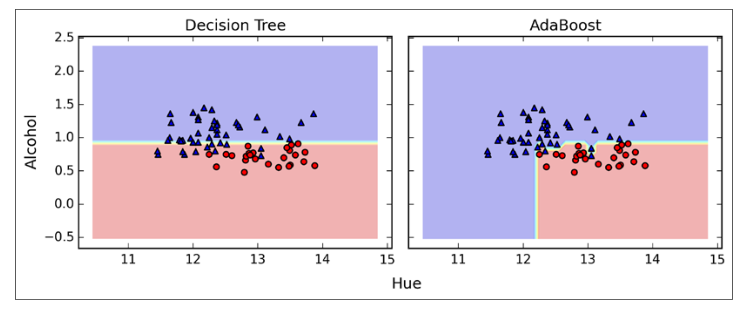

As concluding remarks about ensemble techniques, it is worth noting that
ensemble learning increases the computational complexity compared to individual
classifiers. In practice, we need to think carefully whether we want to pay the price of increased computational costs for an often relatively modest improvement of
predictive performance.

This chapter ended!